https://services.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-145.4,36.7,-116.6,54.3&bboxSR=4326&layers=0&size=210,150&imageSR=4326&format=png&transparent=false&dpi=300&f=image


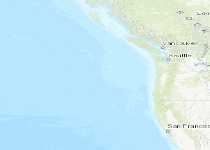

In [1]:
# Tools needed
from PIL import Image
import requests
from io import BytesIO
import rasterio
from rasterio import features
import pprint
import numpy as np
from rasterio.io import MemoryFile
from rasterio.plot import show, reshape_as_raster
from rasterio.transform import from_bounds
from imageio import imread
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import json
from shapely.geometry import shape
from pyproj import CRS, Transformer
%matplotlib inline

west = -140
south = 40
east = -122
north = 51

buffer = 0.3

# 1 set desired BBOX to be displayed
# Use format of JSON returned from GP2
bbox = {'type':'Polygon', 'coordinates': [ [ [west, south], [west, north], [east, north], [east, south], [west, south] ] ] }
geojson = {
      "type": "Feature",
      "properties": {},
      "geometry": bbox
}
features =  {
    "type": "FeatureCollection",
    "features": [ geojson ]
}

# 2 get buffered BBOX for displaying map
width_buffer = (east - west) * buffer
height_buffer = (north - south) * buffer

outer_bbox = {
    'west': west - width_buffer,
    'east': east + width_buffer,
    'north': north + height_buffer,
    'south': south - height_buffer,
}
if outer_bbox['west'] < -180:
    outer_bbox['west'] = -180
if outer_bbox['east'] > 180:
    outer_bbox['east'] = 180
if outer_bbox['south'] < -90:
    outer_bbox['south'] = -90
if outer_bbox['north'] > 90:
    outer_bbox['north'] = 90
    
# 3 set image size
size = {'width': 210, 'height': 150}

# 4 query for basemap
url = 'https://services.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export'
args = {
    'bbox':"%s,%s,%s,%s" % (outer_bbox['west'], outer_bbox['south'], outer_bbox['east'], outer_bbox['north']),
    'bboxSR': '4326',
    'layers': '0',
    'size': "%s,%s" % (size['width'], size['height']),
    'imageSR': '4326',
    'format': 'png',
    'transparent': 'false',
    'dpi': '300',
    'f': 'image'
}

# Example:
# https://services.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer/export?
#     bbox=-143%2C38%2C-119%2C53&
#     bboxSR=4326&
#     layers=0&
#     layerDefs=&
#     size=210%2C150&
#     imageSR=4326&
#     format=png&
#     transparent=false&
#     dynamicLayers=&
#     f=image

qs = "?"
qs_list = []
for key in args.keys():
    qs_list.append("%s=%s" % (key, args[key]))

qs += '&'.join(qs_list)
url = url + qs

print(url)

#5 get basemap as image

response = requests.get(url)
data = response.content
img = Image.open(BytesIO(data))
img


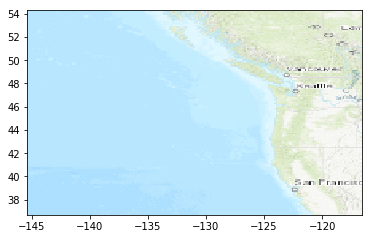

In [2]:
# 6 read image result into rasterio 

BBOX = outer_bbox['west'], outer_bbox['south'], outer_bbox['east'], outer_bbox['north']
affine_transform = from_bounds(*BBOX, size['width'], size['height'])

base_img = imread(BytesIO(data))
base_img.shape
plt.imshow(base_img);

raster = reshape_as_raster(base_img)
show(raster, transform=affine_transform);



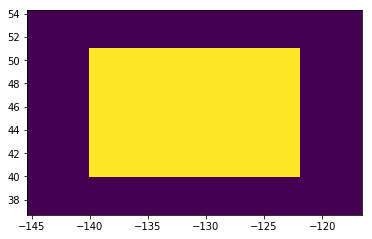

In [3]:

# 7 create bbox feature

raster_box = rasterio.features.rasterize([(bbox,255),], out_shape=[size['height'], size['width']], all_touched=False, transform=affine_transform)
show(raster_box, transform=affine_transform)
# rasterio.plot.show(numpy_array, transform=affine_transform)



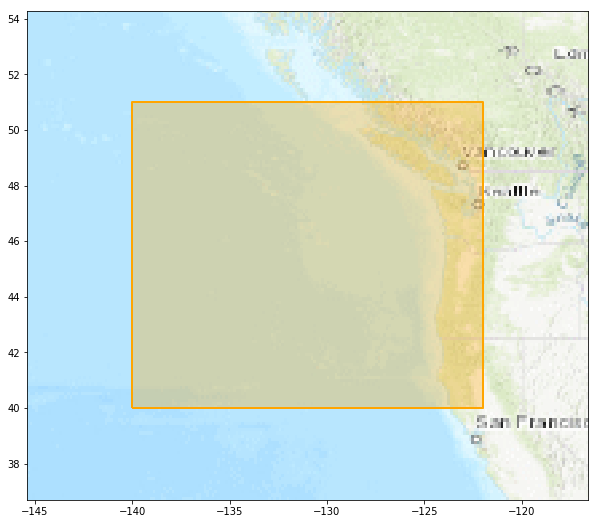

In [4]:
# 8 Put it all together 

fig, ax = plt.subplots(figsize=(12.6,9))

show(raster, transform=affine_transform, ax=ax)

fname = "./bbox.json"

json_str = '{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-140, 40], [-140, 51], [-122, 51], [-122, 40], [-140, 40]]]}}]}'

data = json.loads(json_str)
for d in data['features']:
    # print(str(d))
    d['geometry'] = shape(d['geometry'])

gdf = gpd.GeoDataFrame(data['features'])
gdf.set_geometry('geometry')
gdf.crs = 4326

envelope_overlay = gpd.clip(gdf, mask=box(*BBOX))

envelope_overlay.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
envelope_overlay.plot(ax=ax, facecolor='orange', edgecolor='orange', alpha=0.3)
# ax.axis('off')
plt.show();


[[-140, 40], [-140, 51], [-122, 51], [-122, 40], [-140, 40]]
[[-15584728.711058298, 4865942.279503176], [-15584728.711058298, 6621293.722740169], [-13580977.876779376, 6621293.722740169], [-13580977.876779376, 4865942.279503176], [-15584728.711058298, 4865942.279503176]]


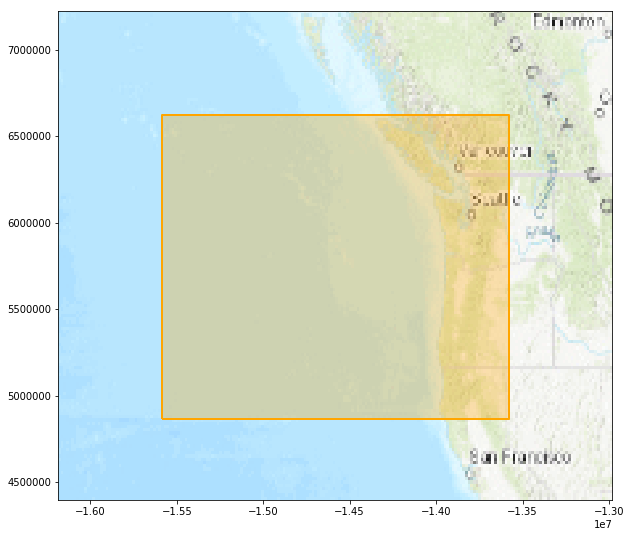

In [5]:
# 9 Do it again, in Mercator
wgs84 = CRS.from_epsg(4326)
mercator = CRS.from_epsg(3857)
transformer = Transformer.from_crs(wgs84, mercator, always_xy=True)
(merc_west, merc_south) = transformer.transform(west, south)
(merc_east, merc_north) = transformer.transform(east, north)

(om_west, om_south) = transformer.transform(outer_bbox['west'], outer_bbox['south'])
(om_east, om_north) = transformer.transform(outer_bbox['east'], outer_bbox['north'])
outer_merc = {
    'west': om_west,
    'south': om_south,
    'east': om_east,
    'north': om_north
}

url = 'https://services.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export'
args = {
    'bbox':"%s,%s,%s,%s" % (om_west, om_south, om_east, om_north),
    'bboxSR': '3857',
    'layers': '0',
    'size': "%s,%s" % (size['width'], size['height']),
    'imageSR': '3857',
    'format': 'png',
    'transparent': 'false',
    'dpi': '300',
    'f': 'image'
}

qs = "?"
qs_list = []
for key in args.keys():
    qs_list.append("%s=%s" % (key, args[key]))

qs += '&'.join(qs_list)
url = url + qs

# print(url)

response = requests.get(url)

OM_BBOX = om_west, om_south, om_east, om_north
om_affine_transform = from_bounds(*OM_BBOX, size['width'], size['height'])

merc_base_img = imread(BytesIO(response.content))
# base_img.shape
# plt.imshow(base_img);

merc_raster = reshape_as_raster(merc_base_img)

merc_fig, merc_ax = plt.subplots(figsize=(12.6,9))

show(merc_raster, transform=om_affine_transform, ax=merc_ax);

merc_json = features
print(merc_json['features'][0]['geometry']['coordinates'][0])
merc_json['features'][0]['geometry']['coordinates'][0] = [
    [merc_west, merc_south], [merc_west, merc_north], [merc_east, merc_north], [merc_east, merc_south], [merc_west, merc_south]
]
print(merc_json['features'][0]['geometry']['coordinates'][0])

for d in merc_json['features']:
    d['geometry'] = shape(d['geometry'])
    
merc_gdf = gpd.GeoDataFrame(merc_json['features'])
merc_gdf.set_geometry('geometry')
merc_gdf.crs = 3857

merc_envelope_overlay = gpd.clip(merc_gdf, mask=box(*OM_BBOX))

merc_envelope_overlay.plot(ax=merc_ax, facecolor='none', edgecolor='orange', linewidth=2)
merc_envelope_overlay.plot(ax=merc_ax, facecolor='orange', edgecolor='orange', alpha=0.3)
# merc_ax.axis('off')
plt.show();



In [6]:


# TODO: Write to Img
# TODO: Return .png (210x150)